### To Do:
##### Determine number of winning / losing trades (win rate)
##### Calculate max drawdown
##### Calculate Sharpe Ratio

In [376]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


In [377]:
data_folder = '/home/lantro/Documents/Algo Trading/LEAN/data/yahoo/'
ticker = 'spy' #'spy' 'eurusd=x' 'BTC-USD' 'tqqq'
warmup_period = 400 # Set this to the length of your longest indicator, i.e. if you calculate a 200 day ma, set it to 200
#df = yf.download(ticker, start='2022-03-17', interval='30m')
#df.to_csv(data_folder+ticker+'.csv')
df = pd.read_csv(f"{data_folder}{ticker}.csv", index_col=[0], parse_dates=True, skipinitialspace=True)
df.rename(columns = {'Close':'close'}, inplace = True)
start_date = '2015-01-01' #Start date for data
end_date = '2016-01-01'
start_date_adjusted = dt.datetime.strptime(start_date, '%Y-%m-%d').date()-dt.timedelta(days = warmup_period*2) # adjust start date to allow time to warmup indicators
df = df.loc[start_date_adjusted:end_date]
long_only = False


In [378]:
# This is my attempt to separate out the plotting from the strategy.
def MACD(df, s, l, signal):
    #Create new dataframe to hold signal values with same index as original df
    # Future: use lag parameter to offset signals when using longer s, l time periods otherwise when you try to use the 
    # combination of MACD signals for buy/sell signals, they won't line up in time, i.e. macd with shorter ema time will get signals earlier
    signal_df = pd.DataFrame(index=df.index)
    signal_df["macd"] = df.close.ewm(span=s, min_periods=1).mean() - df.close.ewm(span=l, min_periods=1).mean()
    signal_df["signal"] = signal_df.macd.ewm(span=signal, min_periods=1).mean()
    signal_df["diff"] = signal_df["macd"] - signal_df["signal"]

    # Cross points (buys / sells)
    # buy_sell_hold: 1 = buy, 0 = hold, -1 = sell
    for i in range(1, len(df)): # This is a slow way to do this. Should use apply or iterrows
        if signal_df.iloc[i-1]["diff"] < 0 and signal_df.iloc[i]["diff"] > 0: # MACD above signal after being below on previous day
            #print("{}:GOLDEN CROSS".format(df.iloc[i].name))
            df.loc[df.iloc[i].name,f's_macd_{s}_{l}_{signal}'] = 1

        elif signal_df.iloc[i-1]["diff"] > 0 and signal_df.iloc[i]["diff"] < 0: # MACD below signal after being above the previous day
            #print("{}:DEAD CROSS".format(df.iloc[i].name))
            df.loc[df.iloc[i].name,f's_macd_{s}_{l}_{signal}'] = -1
        else:
            # Don't do anything, no new signal
            #print("{}:NO CROSS".format(df.iloc[i].name))
            df.loc[df.iloc[i].name,f's_macd_{s}_{l}_{signal}'] = 0  
    return(df,signal_df)


In [379]:
df, macd_df = MACD(df, 12, 26, 9)
#df, macd2_df = MACD(df, 15, 30, 12)


#df[df.iloc[:,-1] == 1] # All rows where last column value = 1
#df[df.iloc[:,7:] == 1] # All rows where last column value = 1
#macd_df.head()
#df.head(20)
# View rows where either signal column signaled a buy 
#df.loc[(df.filter(regex='^s_.*').values == 1).any(axis=1)]

In [380]:
def trend(df, short_period, long_period, pct_over=1):
    #Calculate the required moving averages and difference between the two and return as df
    signal_df = pd.DataFrame(index=df.index)
    signal_df[f'{short_period}_EMA'] = df.close.ewm(span=short_period, min_periods=short_period).mean()
    signal_df[f'{long_period}_EMA'] = df.close.ewm(span=long_period, min_periods=long_period).mean()
    signal_df[f'{short_period}-{long_period}_diff'] = signal_df[f'{short_period}_EMA']-signal_df[f'{long_period}_EMA']
    signal_df[f's_uptrend_{short_period}-{long_period}'] = (np.where((signal_df[f'{short_period}-{long_period}_diff'] >= (signal_df[f'{long_period}_EMA']*pct_over*.01)), 1, -1))
    # Don't add to original df #df[f's_uptrend_{short_period}-{long_period}'] = signal_df[f's_uptrend_{short_period}-{long_period}']
    return signal_df

In [381]:
test = trend(df, 20, 50,1)
#test.tail()
#test.filter(regex='^s_.*')

In [382]:
#df.drop('s_uptrend_20-50', axis=1, inplace=True)
#df.tail()

In [383]:
def bullish_ranking(df):
    # We can use some trend indicators to determine how long or short we want to be
    # Calculate some trend indicators, then sum to create a 'bullish' ranking to add to the main df.
    bullish_df = pd.DataFrame(index=df.index)
    bullish_df = bullish_df.join(trend(df, 20, 50,1).filter(regex='^s_.*')) #Just get the signal values from the df
    # Stock above 20 MA
    # 20 MA above 50 MA
    # 50 MA above 200 MA
    #return bullish_df

bullish_ranking(df)
#signal_df[signal_df['bullishness']==1]
#df[df['bullishness']==1]


In [384]:
def set_holdings(df, long_only=False):
    # We are using the 'all' numpy method which evaluates to True only if all items in array evaluate to True
    # Alternatively, we can use the 'any' method
    #We need to account for the fact that we can't buy until the next day, so we should set holdings for following day when we get a signal
    df['buy_sell'] = 0 # Create column to hold buy/sell signals for plotting 
    df['holdings'] = np.NaN # Create new 'holdings column'
    # LONG signals - set holdings
    df.loc[(df.filter(regex='^s_.*').values == 1).all(axis=1),'buy_sell'] = 1
    # SHORT signals - set holdings
    df.loc[(df.filter(regex='^s_.*').values == -1).all(axis=1),'buy_sell'] = -1
    # Set holdings
    df.loc[df['buy_sell'] == 1,'holdings'] = 1
    if long_only == False:
        df.loc[df['buy_sell'] == -1,'holdings'] = -1
    else:
        df.loc[df['buy_sell'] == -1,'holdings'] = 0
    # NEUTRAL signals - we will just fill forward values from rows that had signals to cells with NaN values
    df['holdings'].ffill(inplace=True)
    #Shift the holdings column down by one since we can only buy on the day after we get a signal since it is based on closing prices. This still doesn't account for overnight price change!
    df['holdings'] = df.shift(1)['holdings']
    #return(df)


set_holdings(df, long_only)
#df.head(20)
#df[df['buy_sell'] == -1]
#df[df['holdings'] == 1]

    

In [385]:
#df.head(30)

In [386]:
def periods_in_strategy(start_timestamp, end_timestamp):
    start_date = dt.datetime.date(start_timestamp)
    end_date = dt.datetime.date(end_timestamp)
    days = (end_date - start_date).days
    months = round(days/30, 1)
    years = round(days / 365, 1)
    #print(f'strategy_start: {start_date}')
    #print(f'strategy_start: {end_date}')
    #print(f'days: {days}')
    #print(f'months: {months}')
    #print(f'years: {years}')
    return(days,months,years)


In [387]:
#Adjust dataframes to start with specified start_date now that we have calculated all of our indicators
df = df.loc[start_date:end_date]
macd_df = macd_df.loc[start_date:end_date]
strategy_start = df.iloc[0].name
strategy_end = df.iloc[-1].name
strategy_periods = periods_in_strategy(strategy_start, strategy_end)
print(f'strategy start: {df.iloc[0].name.date()}')
print(f'strategy end: {df.iloc[-1].name.date()}')
print(f'strategy_days: {strategy_periods[0]}')
print(f'strategy_months: {strategy_periods[1]}')
print(f'strategy_years: {strategy_periods[2]}')

strategy start: 2015-01-02
strategy end: 2015-12-31
strategy_days: 363
strategy_months: 12.1
strategy_years: 1.0


In [417]:
def plot_MACD(df,macd_df,returns_df):
    xdate = [x.date() for x in df.index]
    plt.figure(figsize=(30, 30))
    
    # plot the original closing line
    plt.subplot(311) # 3 plots vertically, 1 plot horizontally, this is the 1st plot
    plt.plot(xdate, df.close, label="close")
    plt.scatter(df[df["buy_sell"]==1].index, df[df["buy_sell"]==1]["close"], marker="^", s=100, color="b", alpha=0.9)
    plt.scatter(df[df["buy_sell"]==-1].index, df[df["buy_sell"]==-1]["close"], marker="v", s=100, color="r", alpha=0.9)
    plt.plot(df.close.ewm(span=50, min_periods=25).mean(), label='50_day_EMA')
    plt.plot(df.close.ewm(span=200, min_periods=50).mean(), label='200_day_EMA')
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    
    # plot MACD and signal
    plt.subplot(312) # 3 plots vertically, 1 plot horizontally, this is the 2nd plot
    plt.title("MACD")
    plt.plot(xdate, macd_df.macd, label="macd")
    plt.plot(xdate, macd_df.signal, label="signal")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid(True)

    # Add Buy signals to MACD plot
    plt.scatter(df[df["buy_sell"]==1].index, macd_df[df["buy_sell"]==1]["macd"], marker="o", s=100, color="b", alpha=0.9)
    # Plot Sell signals to MACD plot
    plt.scatter(df[df["buy_sell"]==-1].index, macd_df[df["buy_sell"]==-1]["macd"], marker="o", s=100, color="r", alpha=0.9)
    
    # Plot Cumulative Returns
    plt.subplot(313) # 3 plots vertically, 1 plot horizontally, this is the 3rd plot
    plt.title("Cumulative Returns")
    returns_xdate = [x.date() for x in returns_df.index]
    plt.plot(returns_xdate, returns_df.bh_cum_daily_returns, label="B&H_Cum_Return")
    plt.plot(returns_xdate, returns_df.strategy_cum_daily_returns, label="Strategy_Cum_Return")
    #plt.plot(xdate, returns_df.bh_cum_daily_returns, label="B&H_Cum_Return")
    #plt.plot(xdate, returns_df.strategy_cum_daily_returns, label="Strategy_Cum_Return")
    
    plt.legend()
    plt.grid()
    
    
    # Buy / Sell Signal Plot
    #plt.subplot(314) # 3 plots vertically, 1 plot horizontally, this is the 3rd plot
    #plt.plot(xdate, df.holdings, label="Holdings")

In [421]:
def calculate_returns(df,price_column): #
    # Calculate strategy returns (note date of first trade to use for buy & hold return calc)
    # Calculate buy & hold returns (make sure you adjust dates to account for warmup period)
    #strategy_start = df[df['holdings'] == 1].index[0] #Set the trading start date to first buy for strategy
    #strategy_start = df.iloc[warmup_period].name #Set the trading start date to the end of the warmup period
    strategy_start = df.iloc[0].name #Set the trading start date to the end of the warmup period
    #print(f'strategy_start: {strategy_start}')
    years = periods_in_strategy(strategy_start, df.iloc[-1].name)[2]
    df.loc[:,'bh_daily_returns'] = df[price_column].pct_change()
    df.loc[:,'strategy_daily_returns'] = df['bh_daily_returns'] * df.loc[:,'holdings']
    df = df.iloc[1:,:].copy() #Skip 1st column containing NaN value
    #print(df_daily_returns.tail())

    # Calculate the cumulative daily returns
    df.loc[:,'bh_cum_daily_returns'] = (1 + df['bh_daily_returns']).cumprod() - 1
    df.loc[:,'strategy_cum_daily_returns'] = (1 + df['strategy_daily_returns']).cumprod() - 1
    #print(df_cum_daily_returns.tail())
    bh_cum_return_entire_period = df.loc[:,'bh_cum_daily_returns'].iloc[-1]#.tail(1)
    bh_total_return = round(bh_cum_return_entire_period * 100,2)
    print(f'{dt.datetime.date(df.iloc[0].name)}:  ${round(df.close.iloc[0],2)}')
    print(f'{dt.datetime.date(df.iloc[-1].name)}:  ${round(df.close.iloc[-1],2)}')
    print(f'Total B&H Return:  {bh_total_return}%\t({round(bh_total_return/years,2)}% annualized)')
    strategy_cum_return_entire_period = df.loc[:,'strategy_cum_daily_returns'].iloc[-1]#.tail(1)
    strategy_total_return = round(strategy_cum_return_entire_period * 100,2)
    print(f'Total Strategy Return:  {strategy_total_return}%\t({round(strategy_total_return/years,2)}% annualized)')
    print(f'$10000 investment became ${10000 *(1+strategy_total_return/100)}')
    return(df)
    


In [422]:
def calulate_stats(df):
    pass
    # Determine number of winning / losing trades (win rate)
    # Calculate max drawdown
    # Calculate Sharpe Ratio

2015-01-05:  $201.72
2015-12-31:  $203.87
Total B&H Return:  -0.76%	(-0.76% annualized)
Total Strategy Return:  -15.86%	(-15.86% annualized)
$10000 investment became $8414.0


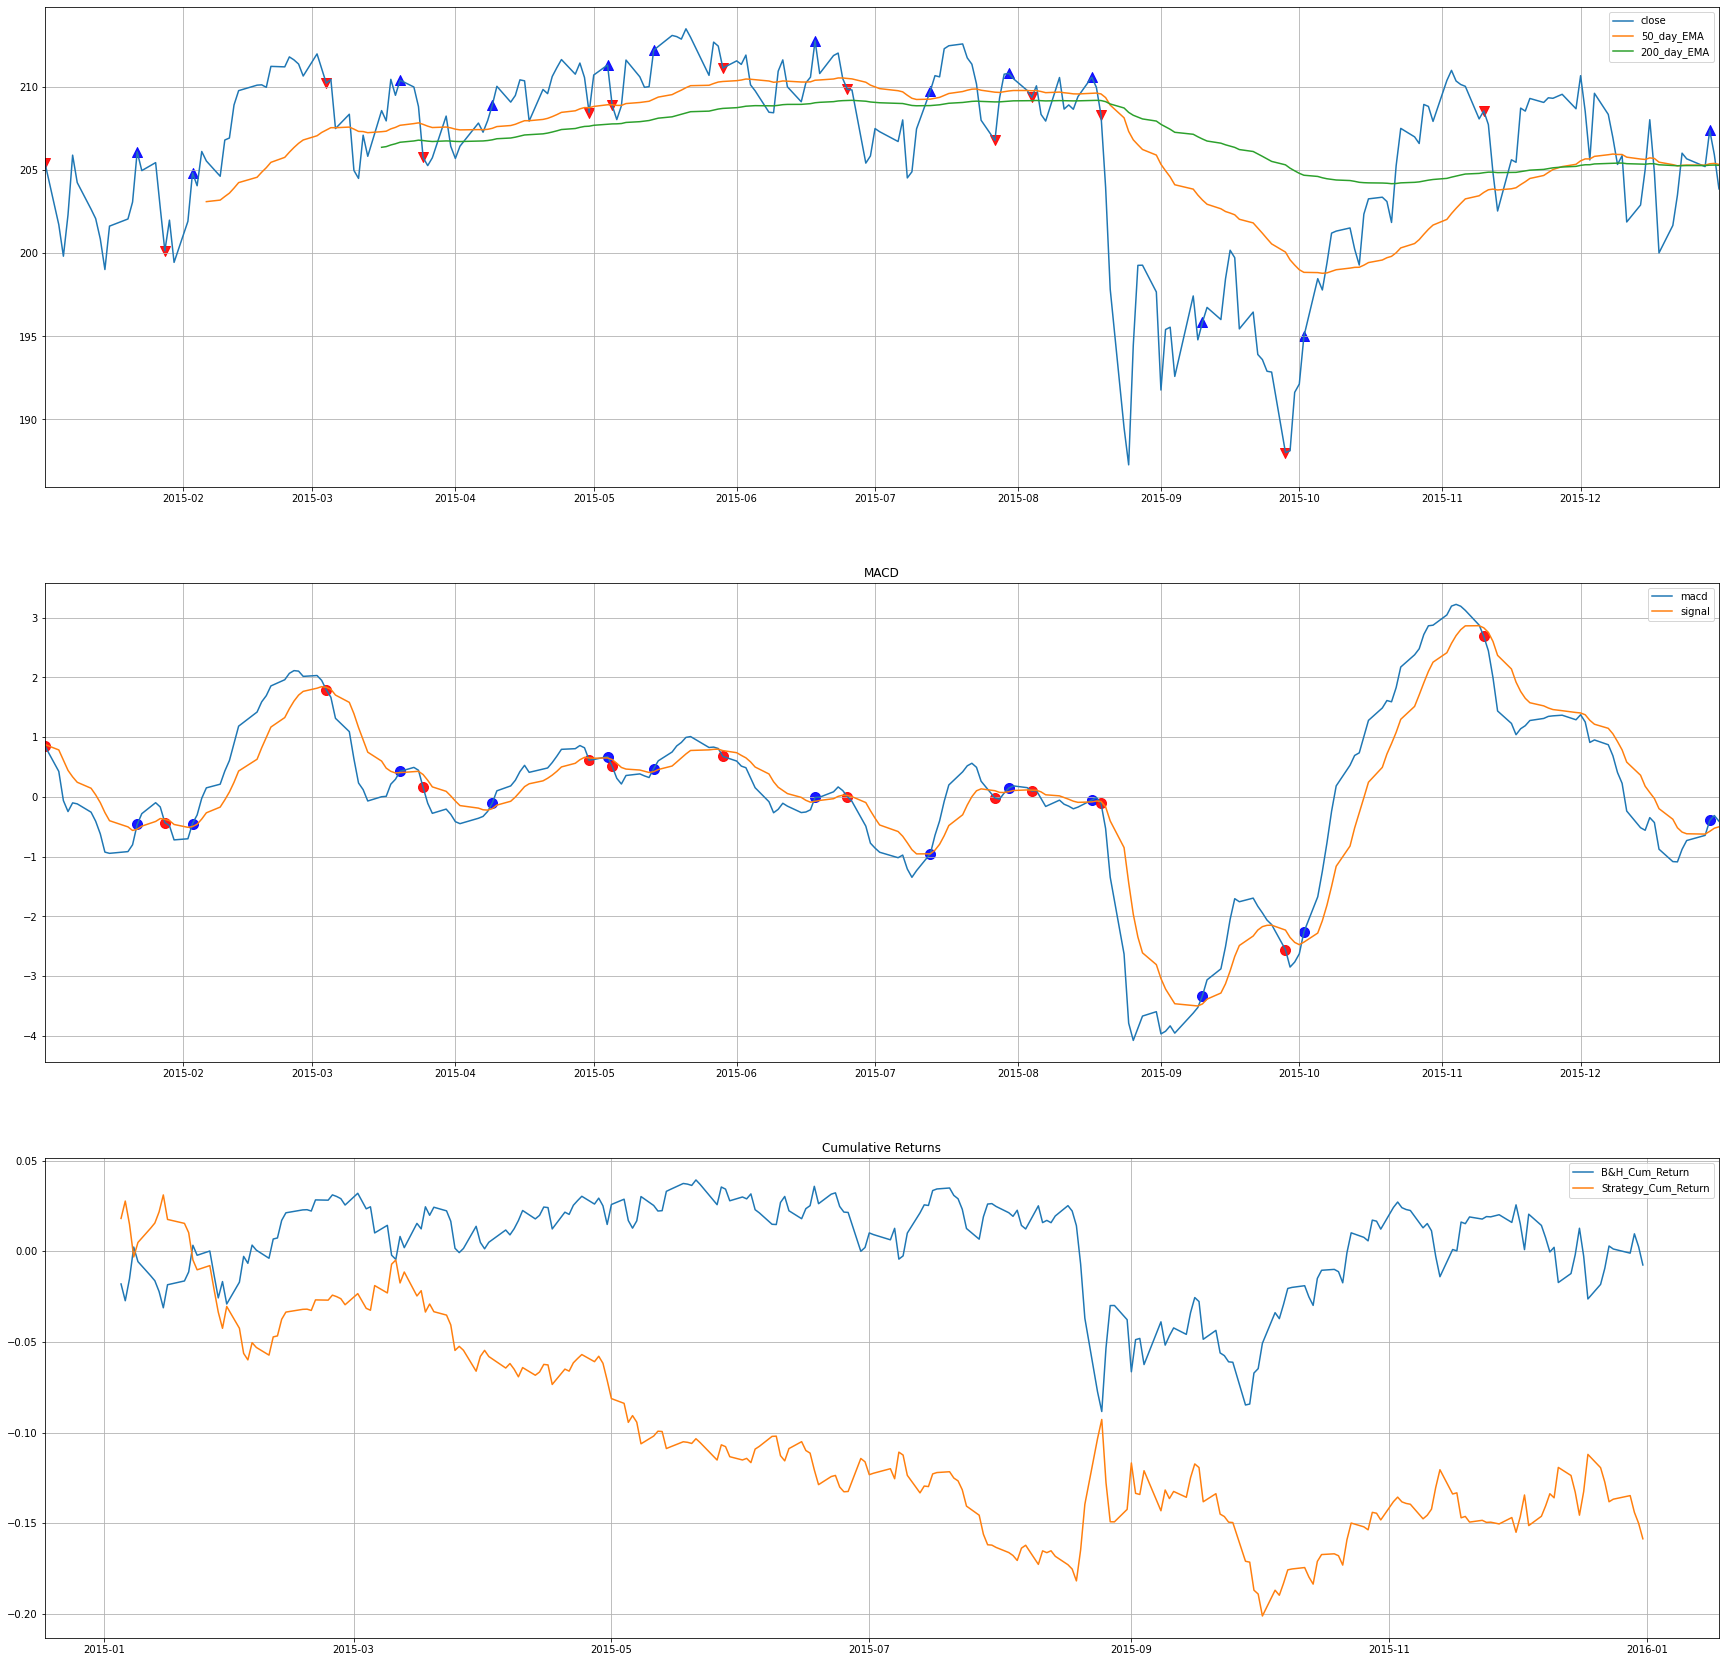

In [423]:

returns_df = calculate_returns(df,'close')
#print(f'returns_df_start: {returns_df.iloc[0].name}')
#print(f'returns_df_end: {returns_df.iloc[-1].name}')

#calulate_stats(df)
plot_MACD(df,macd_df,returns_df)